In [1]:
import pandapower as pp
import pandapower.networks as nx
from pandapower.plotting import simple_plot
import simbench as sb
from pandapower.timeseries.data_sources.frame_data import DFData
from pandapower.control.controller.const_control import ConstControl
import pandapower.timeseries as ts
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandapower import diagnostic

/Users/eddie/.pyenv/versions/3.9.0/envs/cits4001/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Create simple network with grid connection, two loads on separate buses with a solar generator each

In [2]:
net = pp.create_empty_network()

# Create buses
b1 = pp.create_bus(net, vn_kv=20, name="bus 1")
b2 = pp.create_bus(net, vn_kv=0.4, name="bus 2")
b3 = pp.create_bus(net, vn_kv=0.4, name="bus 3")
b4 = pp.create_bus(net, vn_kv=0.4, name="bus 4")
b5 = pp.create_bus(net, vn_kv=0.4, name="bus 5")

# Create external grid
pp.create_ext_grid(net, b1, vm_pu=1.02, name="external grid")

# Create transformer
pp.create_transformer(net, b1, b2, std_type="0.63 MVA 20/0.4 kV")

# Create lines
pp.create_line(net, b2, b3, std_type="NAYY 4x50 SE", length_km=10.0, name="line 1")
pp.create_line(net, b3, b4, std_type="NAYY 4x50 SE", length_km=1.0, name="line 2")
pp.create_line(net, b3, b5, std_type="NAYY 4x50 SE", length_km=1.0, name="line 3")
pp.create_line(net, b4, b5, std_type="NAYY 4x50 SE", length_km=1.0, name="line 4")

# Create loads
pp.create_load(net, 4, p_mw=0.01)
pp.create_load(net, 3, p_mw=0.01)

# Create generators
pp.create_sgen(net, 4, p_mw=0.01)
pp.create_sgen(net, 3, p_mw=0.01)


1

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


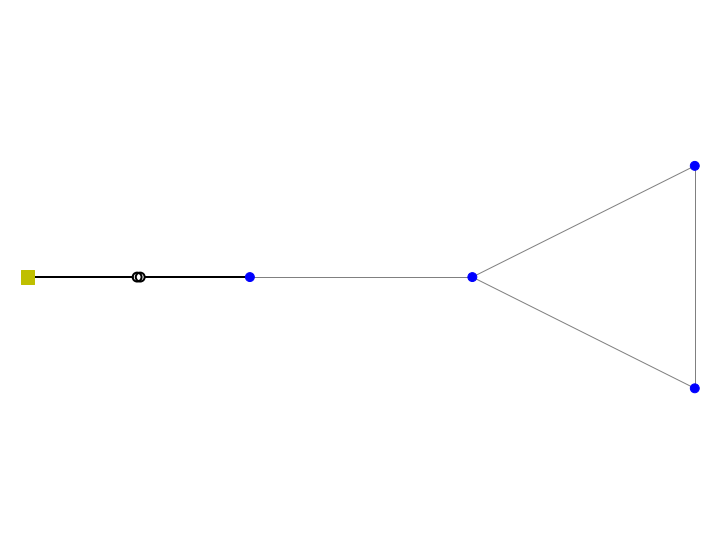

<AxesSubplot:>

In [3]:
simple_plot(net)

## Load in data from sample network

In [4]:
sample_net = sb.get_simbench_net("1-LV-urban6--0-sw")
profiles = sb.get_absolute_values(sample_net, profiles_instead_of_study_cases=True)

/Users/eddie/.pyenv/versions/3.9.0/envs/cits4001/lib/python3.9/site-packages/simbench/converter/csv_pp_converter.py:390: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  idx_bus = data["Measurement"].index.difference(idx_line | idx_trafo).astype(int)
/Users/eddie/.pyenv/versions/3.9.0/envs/cits4001/lib/python3.9/site-packages/simbench/converter/csv_pp_converter.py:468: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  missing = csv_data["Line"].index.difference(idx_lines | idx_dclines)
/Users/eddie/.pyenv/versions/3.9.0/envs/cits4001/lib/python3.9/site-packages/simbench/converter/csv_pp_converter.py:472: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Seri

In [5]:
load_p = profiles[("load", "p_mw")]
load_q = profiles[("load", "q_mvar")]
sgen_p = profiles[("sgen", "p_mw")]

In [6]:
# Select two random loads and sgens that are on the same bus
SELECTED_LOADS = [37, 108]
SELECTED_SGENS = [0, 2]
# Drop all but two loads and gens
load_p = load_p.iloc[:, SELECTED_LOADS].reset_index(drop=True)
load_q = load_q.iloc[:, SELECTED_LOADS].reset_index(drop=True)
sgen_p = sgen_p.iloc[:, SELECTED_SGENS].reset_index(drop=True)

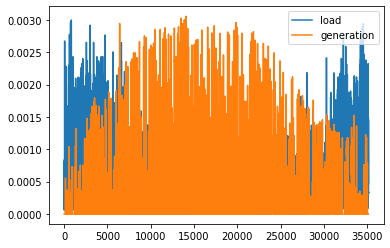

In [7]:
load_p.iloc[:, 0].plot(label="load")
sgen_p.iloc[:, 0].plot(label="generation")
plt.legend()
plt.show()

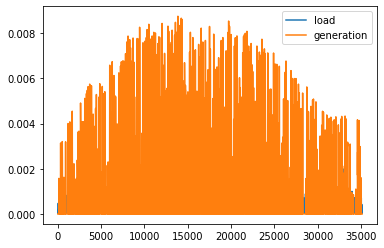

In [8]:
load_p.iloc[:, 1].plot(label="load")
sgen_p.iloc[:, 1].plot(label="generation")
plt.legend()
plt.show()

## Clearly we need additional loads on the bus as this solar system appears to be much larger than the load

In [9]:
data_source = DFData(sgen_p)
ConstControl(
    net,
    "sgen",
    "p_mw",
    element_index=net.sgen.index,
    profile_name=sgen_p.columns,
    data_source=data_source,
)

data_source = DFData(load_p)
ConstControl(
    net,
    "load",
    "p_mw",
    element_index=net.load.index,
    profile_name=load_p.columns,
    data_source=data_source,
)
data_source = DFData(load_q)
ConstControl(
    net,
    "load",
    "p_mvar",
    element_index=net.load.index,
    profile_name=load_q.columns,
    data_source=data_source,
)

This ConstControl has the following parameters: 

index:             2
json_excludes:     ['self', '__class__']

In [ ]:
ts.OutputWriter(net, output_path="./out", output_file_type=".json")
ts.run_time_series.run_timeseries(net)

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps


Progress: |██████████████████████----------------------------| 45.7% Complete

In [ ]:
bus_vm_pu = pd.read_json("./out/res_bus/vm_pu.json")

In [ ]:
bus_vm_pu

In [ ]:
# Let's plot the results from one of the buses with a generator and a load on it
g = sns.lineplot(x="index", y=4, data=bus_vm_pu.reset_index())
_ = g.set_yticks(np.linspace(0, 1.1, 18))


In [ ]:
g = sns.lineplot(x="index", y=3, data=bus_vm_pu.reset_index())
_ = g.set_yticks(np.linspace(0, 1.1, 18))

## Unsurpisingly, these buses have big voltage violations as there is a lot of generation and very little load